In [71]:
import os
import re
import numpy as np
import pandas as pd
import nltk
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from nltk.corpus import stopwords
from email.parser import BytesParser
from email.policy import default
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer


In [57]:
# Load the data
ham_path = 'ham'
spam_path = 'spam'
ham_files = os.listdir(ham_path)
spam_files = os.listdir(spam_path)
ham_df = pd.DataFrame({'email': [open(os.path.join(ham_path, file), 'rb').read() for file in ham_files], 'label': np.zeros(len(ham_files))})
spam_df = pd.DataFrame({'email': [open(os.path.join(spam_path, file), 'rb').read() for file in spam_files], 'label': np.ones(len(spam_files))})
full_data = pd.concat([ham_df, spam_df], axis=0, ignore_index=True)

In [58]:
# Extract the email subject and content
full_data['Subject'] = full_data['email'].apply(lambda x: BytesParser(policy=default).parsebytes(x)['Subject'])
full_data['content'] = full_data['email'].apply(lambda x: BytesParser(policy=default).parsebytes(x).get_payload())


In [59]:
# Text preprocessing
stemmer = nltk.porter.PorterStemmer()
stop_words = stopwords.words('english')
punctuation = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~'
full_data['content'] = full_data['content'].apply(lambda text: ' '.join([stemmer.stem(w) for w in re.sub('[{}]'.format(punctuation),'',str(text)).lower().split() if w not in stop_words]))
full_data['Subject'] = full_data['Subject'].apply(lambda text: ' '.join([stemmer.stem(w) for w in re.sub('[{}]'.format(punctuation),'',str(text)).lower().split() if w not in stop_words]))

full_data = full_data.dropna().reset_index(drop=True)

In [60]:
# Vectorize the content and split the data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(full_data['content'])
y = full_data['label'].astype(int)
trainx, testx, trainy, testy = train_test_split(X, y, stratify=y, random_state=42)



In [61]:
# Print information about the data
print("\ndata information:")
full_data_new = full_data[['label', 'content']]
print(full_data_new.info())
print("\ndata view:")
print(full_data_new.sample(5))


data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3302 entries, 0 to 3301
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   label    3302 non-null   float64
 1   content  3302 non-null   object 
dtypes: float64(1), object(1)
memory usage: 51.7+ KB
None

data view:
      label                                            content
1864    0.0  peopl much time hand look first 8meg take loon...
1380    0.0  chuck murcko wrote heh ten year ago say exact ...
110     0.0  url httpwwwaaronswcomweblog000637 date 2002100...
2691    0.0  url httpwwwnewsisfreecomclick08358764215 date ...
761     0.0  way tell spamassassin put result bottom messag...


Training set:
0    2100
1     376
Name: label, dtype: int64


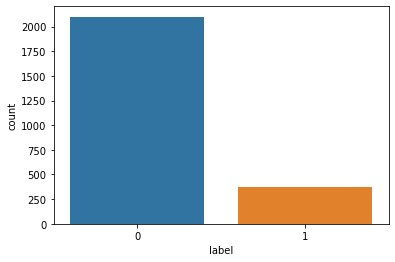

In [62]:
# Check for class imbalance in the training set
print("Training set:")
class_counts = trainy.value_counts()
print(class_counts)
sns.countplot(x=trainy)
plt.show()



Testing set:
0    701
1    125
Name: label, dtype: int64


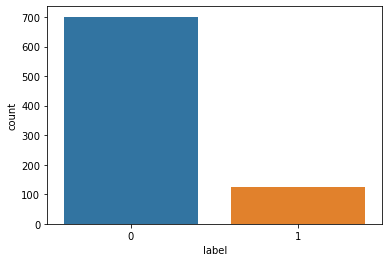

In [63]:
# Check for class imbalance in the testing set
print("Testing set:")
class_counts = testy.value_counts()
print(class_counts)
sns.countplot(x=testy)
plt.show()



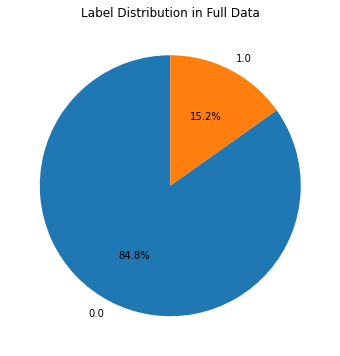

In [64]:
label_distribution = full_data['label'].value_counts()

# Plotting
plt.figure(figsize=(6,6))
plt.pie(label_distribution, labels=label_distribution.index, autopct='%1.1f%%', startangle=90)
plt.title('Label Distribution in Full Data')
plt.show()

In [65]:
# Define the models and their hyperparameters to be tuned

models = {
          'svm_rbf': (SVC(), 
                         {'C': [0.1, 0.5, 1.5, 1, 10], 
                          'gamma': [1, 0.1, 0.01],  
                          'kernel': ['rbf']}),
          'knn': (KNeighborsClassifier(), 
                  {'n_neighbors': [5, 7, 9, 10, 11, 13, 15], 
                   'p': [1, 2], 
                   'weights': ['uniform', 'distance'], 
                   'algorithm': ['auto']}),
          'nb_multinomial': (MultinomialNB(), 
                             {'alpha': [0.1, 0.5, 1, 2, 10], 
                              'fit_prior': [True, False]})}




Processing Model: svm_rbf
--------------------------------------------------
Tuning hyperparameters for accuracy...
Best accuracy parameters found: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

Metrics with best accuracy parameters:
accuracy: 0.9407
roc-auc: 0.8073
f1-score: 0.7586
recall: 0.6160
precision: 0.9872

Confusion matrix with best accuracy parameters:
[[700   1]
 [ 48  77]]


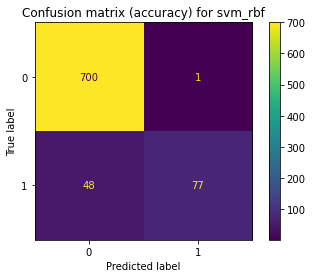


Tuning hyperparameters for precision...
Best precision parameters found: {'C': 0.5, 'gamma': 0.01, 'kernel': 'rbf'}

Metrics with best precision parameters:
accuracy: 0.8898
roc-auc: 0.6360
f1-score: 0.4277
recall: 0.2720
precision: 1.0000

Confusion matrix with best precision parameters:
[[701   0]
 [ 91  34]]


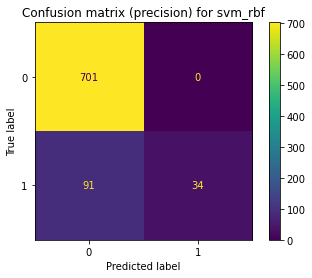

Tuning hyperparameters for f1 score...
Best f1 score parameters found: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

Metrics with best f1 score parameters:
accuracy: 0.9407
roc-auc: 0.8073
f1-score: 0.7586
recall: 0.6160
precision: 0.9872

Confusion matrix with best f1 score parameters:
[[700   1]
 [ 48  77]]


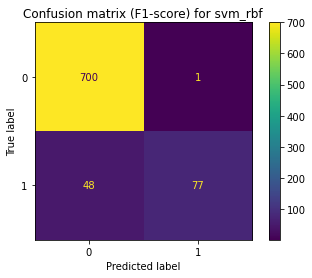


Processing Model: knn
--------------------------------------------------
Tuning hyperparameters for accuracy...
Best accuracy parameters found: {'algorithm': 'auto', 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}

Metrics with best accuracy parameters:
accuracy: 0.8317
roc-auc: 0.8220
f1-score: 0.5924
recall: 0.8080
precision: 0.4676

Confusion matrix with best accuracy parameters:
[[586 115]
 [ 24 101]]


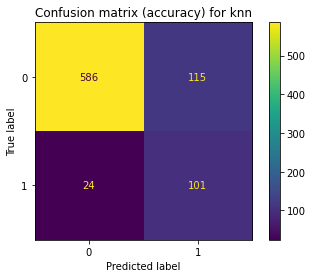


Tuning hyperparameters for precision...
Best precision parameters found: {'algorithm': 'auto', 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}

Metrics with best precision parameters:
accuracy: 0.8317
roc-auc: 0.8220
f1-score: 0.5924
recall: 0.8080
precision: 0.4676

Confusion matrix with best precision parameters:
[[586 115]
 [ 24 101]]


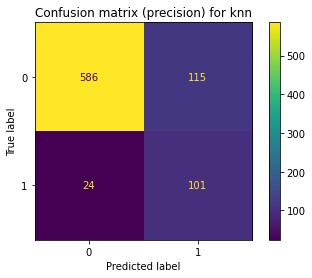

Tuning hyperparameters for f1 score...
Best f1 score parameters found: {'algorithm': 'auto', 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}

Metrics with best f1 score parameters:
accuracy: 0.8317
roc-auc: 0.8220
f1-score: 0.5924
recall: 0.8080
precision: 0.4676

Confusion matrix with best f1 score parameters:
[[586 115]
 [ 24 101]]


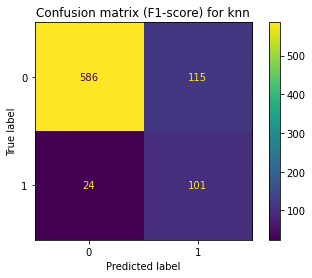


Processing Model: nb_multinomial
--------------------------------------------------
Tuning hyperparameters for accuracy...
Best accuracy parameters found: {'alpha': 0.5, 'fit_prior': True}

Metrics with best accuracy parameters:
accuracy: 0.9370
roc-auc: 0.9432
f1-score: 0.8207
recall: 0.9520
precision: 0.7212

Confusion matrix with best accuracy parameters:
[[655  46]
 [  6 119]]


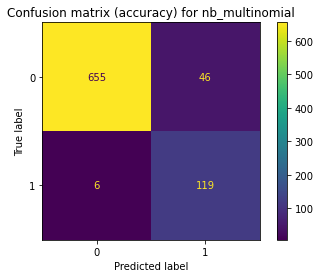


Tuning hyperparameters for precision...
Best precision parameters found: {'alpha': 10, 'fit_prior': True}

Metrics with best precision parameters:
accuracy: 0.8692
roc-auc: 0.5680
f1-score: 0.2394
recall: 0.1360
precision: 1.0000

Confusion matrix with best precision parameters:
[[701   0]
 [108  17]]


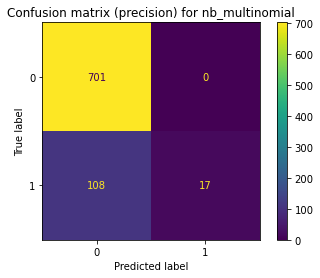

Tuning hyperparameters for f1 score...
Best f1 score parameters found: {'alpha': 0.1, 'fit_prior': True}

Metrics with best f1 score parameters:
accuracy: 0.9358
roc-auc: 0.9458
f1-score: 0.8191
recall: 0.9600
precision: 0.7143

Confusion matrix with best f1 score parameters:
[[653  48]
 [  5 120]]


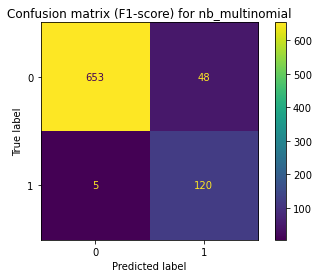

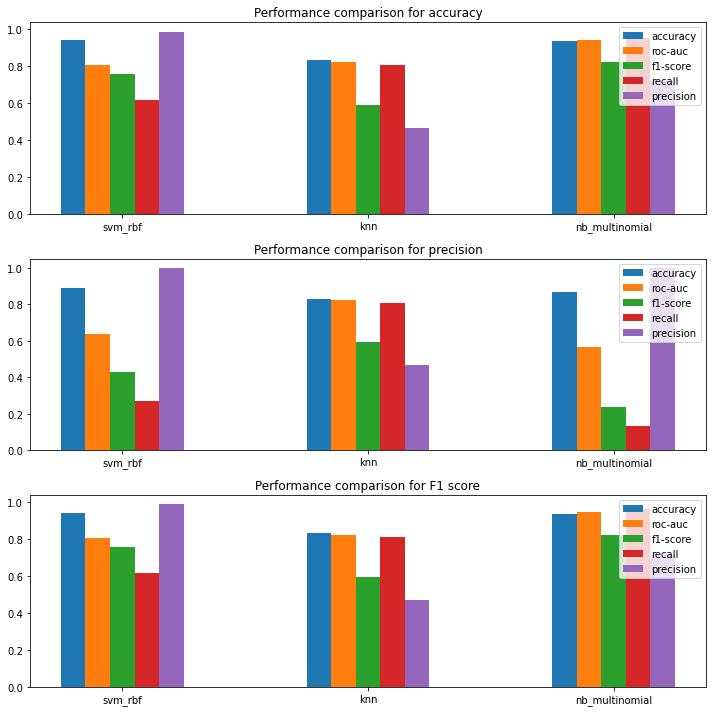

In [67]:
# Tune the hyperparameters and evaluate the models
best_params_acc = {}
best_params_prec = {}
best_params_f1 = {}
f1_scorer = make_scorer(f1_score, zero_division=0)
precision_scorer = make_scorer(precision_score, zero_division=0)

metrics_acc_all = {}
metrics_prec_all = {}
metrics_f1_all = {}

for name, (model, params) in models.items():
    print(f'\nProcessing Model: {name}\n' + '-'*50)
    
    # Tuning for best accuracy
    print('Tuning hyperparameters for accuracy...')
    grid_search_acc = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
    grid_search_acc.fit(trainx, trainy)
    best_params_acc[name] = grid_search_acc.best_params_
    print('Best accuracy parameters found:', best_params_acc[name])
    
    # Evaluation with best accuracy parameters
    model.set_params(**best_params_acc[name])
    model.fit(trainx, trainy)
    y_pred_acc = model.predict(testx)
    
    metrics_acc = {'accuracy': accuracy_score(testy, y_pred_acc),
                   'roc-auc': roc_auc_score(testy, y_pred_acc),
                   'f1-score': f1_score(testy, y_pred_acc),
                   'recall': recall_score(testy, y_pred_acc),
                   'precision': precision_score(testy, y_pred_acc, zero_division=0)}
    
    print('\nMetrics with best accuracy parameters:')
    for metric, value in metrics_acc.items():
        print(f'{metric}: {value:.4f}')
        
    
    print("\nConfusion matrix with best accuracy parameters:")
    cm_acc = confusion_matrix(testy, y_pred_acc)
    print(cm_acc)
    plot_confusion_matrix(model, testx, testy)
    plt.title(f'Confusion matrix (accuracy) for {name}')
    plt.show()

    # Tuning for best precision
    print('\nTuning hyperparameters for precision...')
    precision_scorer = make_scorer(precision_score, zero_division=0)
    grid_search_prec = GridSearchCV(model, params, cv=5, scoring=precision_scorer, n_jobs=-1, verbose=0)
    grid_search_prec.fit(trainx, trainy)
    best_params_prec[name] = grid_search_prec.best_params_
    print('Best precision parameters found:', best_params_prec[name])
    
    # Evaluation with best precision parameters
    model.set_params(**best_params_prec[name])
    model.fit(trainx, trainy)
    y_pred_prec = model.predict(testx)
    
    metrics_prec = {'accuracy': accuracy_score(testy, y_pred_prec),
                    'roc-auc': roc_auc_score(testy, y_pred_prec),
                    'f1-score': f1_score(testy, y_pred_prec),
                    'recall': recall_score(testy, y_pred_prec),
                    'precision': precision_score(testy, y_pred_prec, zero_division=0)}
    
    print('\nMetrics with best precision parameters:')
    for metric, value in metrics_prec.items():
        print(f'{metric}: {value:.4f}')
        
    print("\nConfusion matrix with best precision parameters:")
    cm_prec = confusion_matrix(testy, y_pred_prec)
    print(cm_prec)
    plot_confusion_matrix(model, testx, testy)
    plt.title(f'Confusion matrix (precision) for {name}')
    plt.show()
    
    # Tuning for best f1 score
    print('Tuning hyperparameters for f1 score...')
    grid_search_f1 = GridSearchCV(model, params, cv=5, scoring=f1_scorer, n_jobs=-1, verbose=0)
    grid_search_f1.fit(trainx, trainy)
    best_params_f1[name] = grid_search_f1.best_params_
    print('Best f1 score parameters found:', best_params_f1[name])
    
    # Evaluation with best f1 score parameters
    model.set_params(**best_params_f1[name])
    model.fit(trainx, trainy)
    y_pred_f1 = model.predict(testx)
    
    metrics_f1 = {'accuracy': accuracy_score(testy, y_pred_f1),
                   'roc-auc': roc_auc_score(testy, y_pred_f1),
                   'f1-score': f1_score(testy, y_pred_f1),
                   'recall': recall_score(testy, y_pred_f1),
                   'precision': precision_score(testy, y_pred_f1, zero_division=0)}
    
    print('\nMetrics with best f1 score parameters:')
    for metric, value in metrics_f1.items():
        print(f'{metric}: {value:.4f}')
        
    print("\nConfusion matrix with best f1 score parameters:")
    cm_f1 = confusion_matrix(testy, y_pred_f1)
    print(cm_f1)
    plot_confusion_matrix(model, testx, testy)
    plt.title(f'Confusion matrix (F1-score) for {name}')
    plt.show()
    
    
    # Store metrics
    metrics_acc_all[name] = metrics_acc
    metrics_prec_all[name] = metrics_prec
    metrics_f1_all[name] = metrics_f1
    
   
    
    

# Define the metric names and number of models
metrics_names = ['accuracy', 'roc-auc', 'f1-score', 'recall', 'precision']
num_models = len(models)

# Create subplots for accuracy and precision and f1
fig, axs = plt.subplots(3, figsize=(10, 10))

# Plot for accuracy
for i, metric in enumerate(metrics_names):
    values = [metrics_acc_all[model][metric] for model in models.keys()]
    axs[0].bar(np.arange(num_models) + i*0.1, values, width=0.1, label=metric)
axs[0].set_title('Performance comparison for accuracy')
axs[0].set_xticks(np.arange(num_models) + 0.2)
axs[0].set_xticklabels(models.keys())
axs[0].legend()

# Plot for precision
for i, metric in enumerate(metrics_names):
    values = [metrics_prec_all[model][metric] for model in models.keys()]
    axs[1].bar(np.arange(num_models) + i*0.1, values, width=0.1, label=metric)
axs[1].set_title('Performance comparison for precision')
axs[1].set_xticks(np.arange(num_models) + 0.2)
axs[1].set_xticklabels(models.keys())
axs[1].legend()

# Plot for f1
for i, metric in enumerate(metrics_names):
    values = [metrics_f1_all[model][metric] for model in models.keys()]
    axs[2].bar(np.arange(num_models) + i*0.1, values, width=0.1, label=metric)
axs[2].set_title('Performance comparison for F1 score')
axs[2].set_xticks(np.arange(num_models) + 0.2)
axs[2].set_xticklabels(models.keys())
axs[2].legend()


# Display plots
plt.tight_layout()
plt.show()



In [73]:
models_new = {
    'svm_linear': (SVC(kernel='linear'), 
                   {'C': [0.1, 0.5, 1.5, 1, 10]}),
    'random_forest': (RandomForestClassifier(), 
                      {'n_estimators': [50, 100, 200], 
                       'max_depth': [None, 10, 20, 30], 
                       'min_samples_split': [2, 5, 10]})
}

In [78]:
best_params_new = {}
f1_scorer = make_scorer(f1_score, zero_division=0)
precision_scorer = make_scorer(precision_score, zero_division=0)
recall_scorer = make_scorer(recall_score, zero_division=0)

for model_name in models_new.keys():
    clf = GridSearchCV(models_new[model_name][0], models_new[model_name][1], cv=5)
    clf.fit(trainx, trainy)
    best_params_new[model_name] = clf.best_params_
    preds = clf.predict(testx)
    print(f'---{model_name}---')
    print(f'Best parameters: {best_params_new[model_name]}')
    print(f'Accuracy: {accuracy_score(testy, preds)}')
    print(f'ROC AUC: {roc_auc_score(testy, preds)}')
    print(f'F1: {f1_scorer(clf, testx, testy)}')
    print(f'Precision: {precision_scorer(clf, testx, testy)}')
    print(f'Recall: {recall_scorer(clf, testx, testy)}')

    importances = None

    if hasattr(clf.best_estimator_, 'feature_importances_'):
        importances = clf.best_estimator_.feature_importances_
    elif hasattr(clf.best_estimator_, 'coef_'):
        importances = np.abs(clf.best_estimator_.coef_.toarray().flatten())

    if importances is not None:
        # Get the feature names
        feature_names = vectorizer.get_feature_names()
        # Sort the features by importance
        sorted_indices = np.argsort(importances)[::-1]
        print("\nTop 10 features:")
        for i in sorted_indices[:10]:
            print(f"{feature_names[i]}: {importances[i]:.4f}")


---svm_linear---
Best parameters: {'C': 0.1}
Accuracy: 0.9539951573849879
ROC AUC: 0.880867332382311
F1: 0.8362068965517242
Precision: 0.9065420560747663
Recall: 0.776

Top 10 features:
date: 0.3084
url: 0.2802
wrote: 0.2489
pleas: 0.2300
click: 0.2201
bodi: 0.1954
html: 0.1874
visit: 0.1872
remov: 0.1765
guarante: 0.1586
---random_forest---
Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.9552058111380145
ROC AUC: 0.8651469329529243
F1: 0.832579185520362
Precision: 0.9583333333333334
Recall: 0.736

Top 10 features:
emailmessageemailmessag: 0.0280
object: 0.0216
click: 0.0073
remov: 0.0049
date: 0.0049
herea: 0.0046
content3dtexthtml: 0.0045
use: 0.0043
url: 0.0043
wish: 0.0043
